# Implementação de MLP Multi-Camadas para Fashion MNIST

Este notebook implementa uma rede neural do tipo Multilayer Perceptron (MLP) com múltiplas camadas ocultas usando apenas NumPy, sem frameworks de deep learning. Vamos usar o dataset Fashion MNIST para classificação de imagens de roupas e acessórios.

## Objetivos
1. Implementar uma MLP flexível com número arbitrário de camadas
2. Comparar diferentes arquiteturas, ativações e inicializações
3. Analisar os resultados para determinar a melhor configuração

# 1. Imports e Preparação dos Dados

Vamos carregar o Fashion MNIST e preparar os dados para treinamento, validação e teste:

In [ ]:
import itertools
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Constantes
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Classes do Fashion MNIST
class_names = [
    "Camiseta/Top",
    "Calça",
    "Pulôver",
    "Vestido",
    "Casaco",
    "Sandália",
    "Camisa",
    "Tênis",
    "Bolsa",
    "Bota",
]

# --- carregar dataset CSV do Kaggle ---
try:
    train_df = pd.read_csv("src/data/fashion_train.csv")
    test_df = pd.read_csv("src/data/fashion_test.csv")
    print(
        f"Dados carregados com sucesso: {train_df.shape[0]} amostras de treino, {test_df.shape[0]} de teste"
    )
except FileNotFoundError:
    print(
        "ERROR: Arquivos de dados não encontrados. Certifique-se de que os arquivos fashion_train.csv e fashion_test.csv estão na pasta src/data/"
    )

# Normalização: dividir por 255 para obter valores entre 0 e 1
X_train_full = train_df.iloc[:, 1:].values.astype(np.float32) / 255.0  #  60 000 × 784
y_train_full = train_df.iloc[:, 0].values.reshape(-1, 1)  #  60 000 × 1
X_test = test_df.iloc[:, 1:].values.astype(np.float32) / 255.0  #  10 000 × 784
y_test = test_df.iloc[:, 0].values.reshape(-1, 1)  #  10 000 × 1

# Converter rótulos para one-hot encoding
enc = OneHotEncoder(sparse_output=False)
y_train_full_oh = enc.fit_transform(y_train_full)
y_test_oh = enc.transform(y_test)

# Separar 10% dos dados de treino para validação
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full_oh,
    test_size=0.10,
    random_state=RANDOM_SEED,
    stratify=y_train_full,
)

print("Dimensões dos dados:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test_oh.shape}")

Dados carregados com sucesso: 60000 amostras de treino, 10000 de teste
Dimensões dos dados:
  X_train: (54000, 784)
  y_train: (54000, 10)
  X_val: (6000, 784)
  y_val: (6000, 10)
  X_test: (10000, 784)
  y_test: (10000, 10)
Dimensões dos dados:
  X_train: (54000, 784)
  y_train: (54000, 10)
  X_val: (6000, 784)
  y_val: (6000, 10)
  X_test: (10000, 784)
  y_test: (10000, 10)


## Visualização de Exemplos do Dataset

Vamos visualizar alguns exemplos para entender melhor os dados que estamos trabalhando:

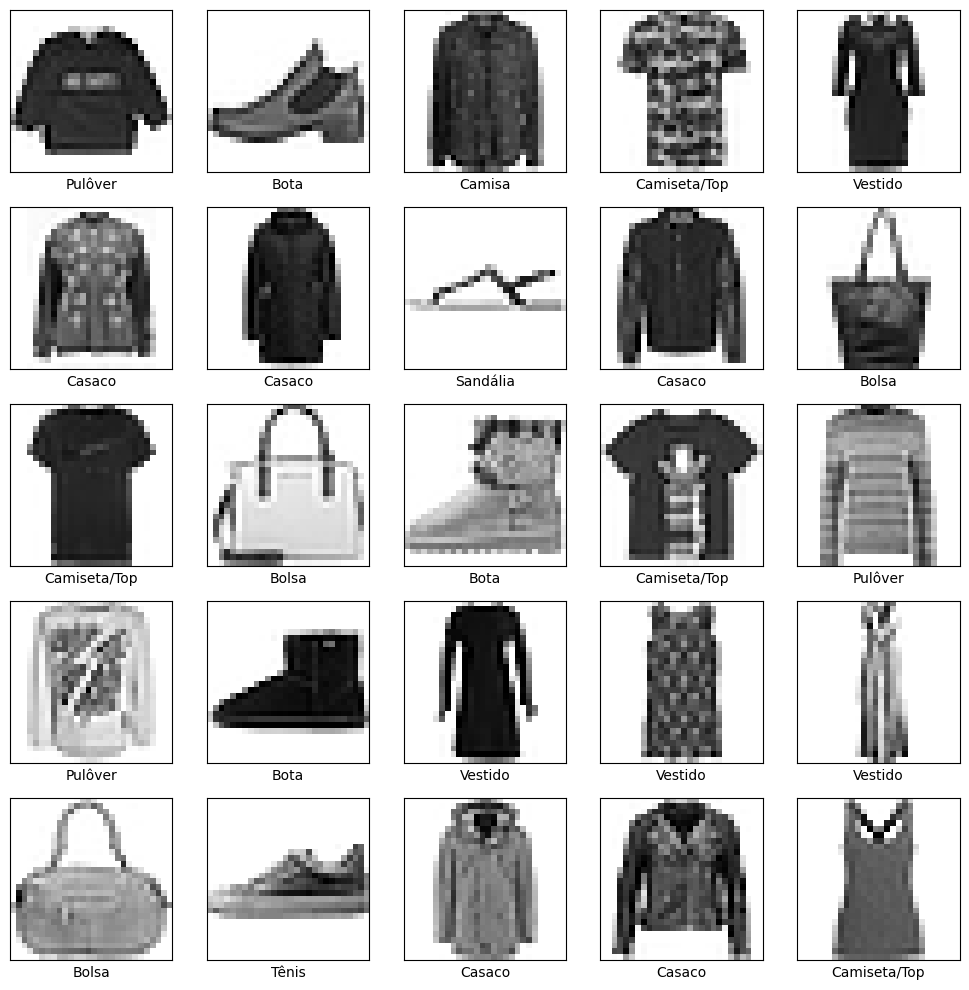

In [ ]:
# Visualizar alguns exemplos do dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = X_train_full[i].reshape(28, 28)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_full[i][0]])
plt.tight_layout()
plt.show()

# 2. Implementação da MLP Multi-Camadas

Vamos implementar uma MLP com suporte a múltiplas camadas, diferentes funções de ativação e métodos de inicialização de pesos.

## Principais características:
- Arquitetura flexível com número arbitrário de camadas ocultas
- Suporte para diferentes funções de ativação (ReLU, Sigmoid, Tanh)
- Inicialização de pesos otimizada (He, Xavier, Random)
- Treino com mini-batch e momentum
- Clipping de gradientes para evitar explosão

In [ ]:
from src.utils.activation import Activation
from src.utils.loss import Loss
from src.utils.metrics import Metrics


class MLPDeep:
    """Multilayer Perceptron com número arbitrário de camadas ocultas."""

    def __init__(
        self,
        layer_sizes: list[int],  # ex.: [784, 256, 128, 10]
        activation: str = "relu",  # função p/ camadas ocultas
        weight_init: str = "he",
        learning_rate: float = 0.01,
        momentum: float = 0.0,
        use_bias: bool = True,
        grad_clip: float = 1.0,  # valor para clipping de gradientes
        random_state: int | None = None,
    ):
        """Inicializa a rede neural.

        Args:
            layer_sizes: Lista com o tamanho de cada camada, incluindo entrada e saída
            activation: Função de ativação para camadas ocultas ('relu', 'sigmoid', 'tanh')
            weight_init: Método de inicialização de pesos ('he', 'xavier', 'random')
            learning_rate: Taxa de aprendizado
            momentum: Valor do momentum (0.0 = sem momentum)
            use_bias: Se deve usar bias nas camadas
            grad_clip: Valor máximo para clipping de gradientes
            random_state: Semente para reprodutibilidade
        """
        if random_state is not None:
            np.random.seed(random_state)

        self.layer_sizes = layer_sizes
        self.L = len(layer_sizes) - 1  # nº de blocos W/b
        self.lr = learning_rate
        self.momentum = momentum
        self.use_bias = use_bias
        self.grad_clip = grad_clip

        self.act_name = activation.lower()
        self.act, self.dact = Activation.get_activation_and_derivative(self.act_name)

        # Inicializações
        self._init_weights(weight_init)
        self._init_velocity()

        # Histórico de treinamento
        self.history = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

    # ---------- inicialização ----------
    def _init_weights(self, method: str):
        """Inicializa os pesos da rede de acordo com o método especificado."""
        self.W, self.b = [], []
        for i in range(self.L):
            fan_in = self.layer_sizes[i]
            fan_out = self.layer_sizes[i + 1]

            # Escolha do método de inicialização
            match method:
                case "xavier":
                    # Adequado para Sigmoid/Tanh
                    std = math.sqrt(1 / fan_in)
                case "he":
                    # Adequado para ReLU
                    std = math.sqrt(2 / fan_in)
                case _:
                    # Inicialização simples com valores pequenos
                    std = 0.01

            self.W.append(np.random.randn(fan_in, fan_out) * std)
            self.b.append(np.zeros((1, fan_out)) if self.use_bias else None)

    def _init_velocity(self):
        """Inicializa os termos de velocidade para o momentum."""
        self.vW = [np.zeros_like(w) for w in self.W]
        self.vb = [np.zeros_like(b) if b is not None else None for b in self.b]

    # ---------- forward pass ----------
    def forward(self, X):
        """Realiza o forward pass pela rede neural.

        Args:
            X: Dados de entrada (batch_size, input_size)

        Returns:
            Saída da rede (batch_size, output_size)
        """
        self.z, self.a = [None] * self.L, [X]  # a[0] = input

        # Propagação pelas camadas ocultas
        for i in range(self.L - 1):
            self.z[i] = self.a[i] @ self.W[i] + (self.b[i] if self.use_bias else 0)
            # Clipping para evitar valores extremos
            self.z[i] = np.clip(self.z[i], -500, 500)
            self.a.append(self.act(self.z[i]))

        # Última camada: sempre usa softmax
        l = self.L - 1
        self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
        # Estabilização numérica da softmax é feita na implementação da função
        self.a.append(Activation.softmax(self.z[l]))
        return self.a[-1]

    # ---------- backward pass ----------
    def backward(self, X, y, y_hat):
        """Realiza o backward pass e atualiza os pesos.

        Args:
            X: Dados de entrada (batch_size, input_size)
            y: Alvos (batch_size, output_size) em one-hot
            y_hat: Saídas preditas (batch_size, output_size)
        """
        batch_size = X.shape[0]
        grads_W, grads_b = [None] * self.L, [None] * self.L

        # 1. Camada de saída (erro de entropia cruzada com softmax)
        delta = y_hat - y  # dL/dz_L (simplificação para CE+softmax)
        l = self.L - 1
        grads_W[l] = (
            self.a[l].T @ delta
        ) / batch_size  # Normalizar pelo tamanho do batch
        grads_b[l] = delta.sum(axis=0, keepdims=True) / batch_size

        # Clipping para evitar explosão de gradientes
        grads_W[l] = np.clip(grads_W[l], -self.grad_clip, self.grad_clip)
        grads_b[l] = np.clip(grads_b[l], -self.grad_clip, self.grad_clip)

        # 2. Camadas ocultas (backpropagation)
        for i in reversed(range(self.L - 1)):
            delta = (delta @ self.W[i + 1].T) * self.dact(self.z[i])  # dL/dz_i
            grads_W[i] = (self.a[i].T @ delta) / batch_size
            grads_b[i] = delta.sum(axis=0, keepdims=True) / batch_size

            # Clipping para todas as camadas
            grads_W[i] = np.clip(grads_W[i], -self.grad_clip, self.grad_clip)
            grads_b[i] = np.clip(grads_b[i], -self.grad_clip, self.grad_clip)

        # 3. Atualização dos pesos com SGD + momentum
        for i in range(self.L):
            # Verificar NaN antes da atualização
            if np.any(np.isnan(grads_W[i])) or np.any(
                np.isnan(grads_b[i] if self.use_bias else 0)
            ):
                print(
                    f"Aviso: Gradientes NaN detectados na camada {i}. Pulando atualização."
                )
                continue

            # Momentum: v_t = momentum * v_{t-1} + gradient
            self.vW[i] = self.momentum * self.vW[i] + grads_W[i]
            self.W[i] -= self.lr * self.vW[i]

            if self.use_bias:
                self.vb[i] = self.momentum * self.vb[i] + grads_b[i]
                self.b[i] -= self.lr * self.vb[i]

    # ---------- utilidades para treinamento ----------
    def train_epoch(self, X, y, batch_size=128):
        """Treina o modelo por uma época completa.

        Args:
            X: Dados de treino
            y: Alvos de treino (one-hot)
            batch_size: Tamanho do mini-batch

        Returns:
            Perda média e acurácia média na época
        """
        idx = np.random.permutation(len(X))  # Embaralhar dados
        losses, accs = [], []

        # Treinamento em mini-batches
        for start in range(0, len(X), batch_size):
            end = start + batch_size
            Xb, yb = X[idx[start:end]], y[idx[start:end]]

            # Forward pass
            y_hat = self.forward(Xb)

            # Backward pass e atualização
            self.backward(Xb, yb, y_hat)

            # Calcular métricas
            loss = Loss.cross_entropy(yb, y_hat)
            acc = (
                Metrics.calculate_accuracy(yb, y_hat) * 100
            )  # Converter para porcentagem

            # Verificar valores inválidos
            if not np.isnan(loss) and not np.isinf(loss):
                losses.append(loss)
                accs.append(acc)
            else:
                print("Aviso: Loss NaN/Inf detectada, pulando batch")

        return np.mean(losses), np.mean(accs)

    def evaluate(self, X, y, batch_size=512):
        """Avalia o modelo em dados de validação/teste.

        Args:
            X: Dados de validação/teste
            y: Alvos (one-hot)
            batch_size: Tamanho do batch para avaliação

        Returns:
            Perda e acurácia
        """
        self.eval_mode = True  # Modo de avaliação (não usado nesta implementação, mas útil para extensões)
        preds = []

        # Avaliação em batches para evitar estouro de memória
        for start in range(0, len(X), batch_size):
            end = start + batch_size
            batch_preds = self.forward(X[start:end])
            preds.append(batch_preds)

        preds = np.vstack(preds)
        loss = Loss.cross_entropy(y, preds)
        acc = Metrics.calculate_accuracy(y, preds) * 100  # Converter para porcentagem

        self.eval_mode = False
        return loss, acc

    def fit(
        self,
        X_train,
        y_train,
        epochs=30,
        batch_size=128,
        X_val=None,
        y_val=None,
        verbose=1,
    ):
        """Treina o modelo por múltiplas épocas com log de progresso.

        Args:
            X_train: Dados de treino
            y_train: Alvos de treino (one-hot)
            epochs: Número de épocas
            batch_size: Tamanho do mini-batch
            X_val: Dados de validação (opcional)
            y_val: Alvos de validação (opcional)
            verbose: Nível de detalhamento (0=silencioso, 1=progresso, 2=detalhado)

        Returns:
            Histórico de treinamento
        """
        best_val_acc = 0
        patience_counter = 0

        for epoch in range(1, epochs + 1):
            # Treinar uma época
            tr_loss, tr_acc = self.train_epoch(X_train, y_train, batch_size=batch_size)
            self.history["train_loss"].append(tr_loss)
            self.history["train_acc"].append(tr_acc)

            # Validação
            if X_val is not None and y_val is not None:
                val_loss, val_acc = self.evaluate(X_val, y_val)
                self.history["val_loss"].append(val_loss)
                self.history["val_acc"].append(val_acc)

                # Log de progresso
                if verbose > 0 and (epoch % 5 == 0 or epoch == epochs):
                    print(
                        f"Época {epoch:3d}/{epochs}: "
                        f"loss={tr_loss:.4f}, acc={tr_acc:.2f}%, "
                        f"val_loss={val_loss:.4f}, val_acc={val_acc:.2f}%"
                    )

                # Acompanhar melhor modelo (para early stopping)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    patience_counter = 0
                else:
                    patience_counter += 1
            elif verbose > 0 and (epoch % 5 == 0 or epoch == epochs):
                print(
                    f"Época {epoch:3d}/{epochs}: loss={tr_loss:.4f}, acc={tr_acc:.2f}%"
                )

        return self.history

    def plot_history(self):
        """Plota o histórico de treinamento."""
        if not self.history["train_loss"]:
            print("Sem histórico de treinamento para mostrar.")
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot de loss
        ax1.plot(self.history["train_loss"], label="Treino")
        if self.history["val_loss"]:
            ax1.plot(self.history["val_loss"], label="Validação")
        ax1.set_title("Loss durante treinamento")
        ax1.set_xlabel("Época")
        ax1.set_ylabel("Loss")
        ax1.legend()

        # Plot de acurácia
        ax2.plot(self.history["train_acc"], label="Treino")
        if self.history["val_acc"]:
            ax2.plot(self.history["val_acc"], label="Validação")
        ax2.set_title("Acurácia durante treinamento")
        ax2.set_xlabel("Época")
        ax2.set_ylabel("Acurácia (%)")
        ax2.legend()

        plt.tight_layout()
        plt.show()

# 3. Experimentos com Hiperparâmetros

Vamos explorar diferentes configurações de hiperparâmetros para encontrar a melhor combinação. Os principais parâmetros a explorar são:

1. **Arquitetura**: número e tamanho das camadas ocultas
2. **Função de ativação**: ReLU, Sigmoid, Tanh
3. **Inicialização de pesos**: He, Xavier, Random

## 3.1 Definição da grade de hiperparâmetros

In [ ]:
param_grid = {
    "hidden_arch": [
        [128],
        [256],
        [256, 128],
    ],  # Diferentes arquiteturas de camadas ocultas
    "act": ["relu", "tanh", "sigmoid"],  # Funções de ativação
    "init": ["he", "xavier", "random"],  # Métodos de inicialização
}

# Criar todas as combinações possíveis de hiperparâmetros
experiments = list(
    itertools.product(param_grid["hidden_arch"], param_grid["act"], param_grid["init"])
)

print(f"Total de {len(experiments)} combinações de hiperparâmetros para testar")

# Mostrar algumas combinações como exemplo
print("\nAlgumas combinações:")
for i, (hid, act, init) in enumerate(experiments[:5]):
    print(f"  {i + 1}. Camadas: {hid}, Ativação: {act}, Inicialização: {init}")

Total de 27 combinações de hiperparâmetros para testar

Algumas combinações:
  1. Camadas: [128], Ativação: relu, Inicialização: he
  2. Camadas: [128], Ativação: relu, Inicialização: xavier
  3. Camadas: [128], Ativação: relu, Inicialização: random
  4. Camadas: [128], Ativação: tanh, Inicialização: he
  5. Camadas: [128], Ativação: tanh, Inicialização: xavier


# 4. Execução dos Experimentos

Vamos treinar modelos com todas as combinações de hiperparâmetros e armazenar os resultados.

## 4.1 Função auxiliar para testes rápidos

Primeiro, vamos testar se nossa implementação funciona corretamente com um único modelo:

Época   3/3: loss=0.6521, acc=78.54%, val_loss=0.6718, val_acc=75.30%


/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: invalid value encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l]

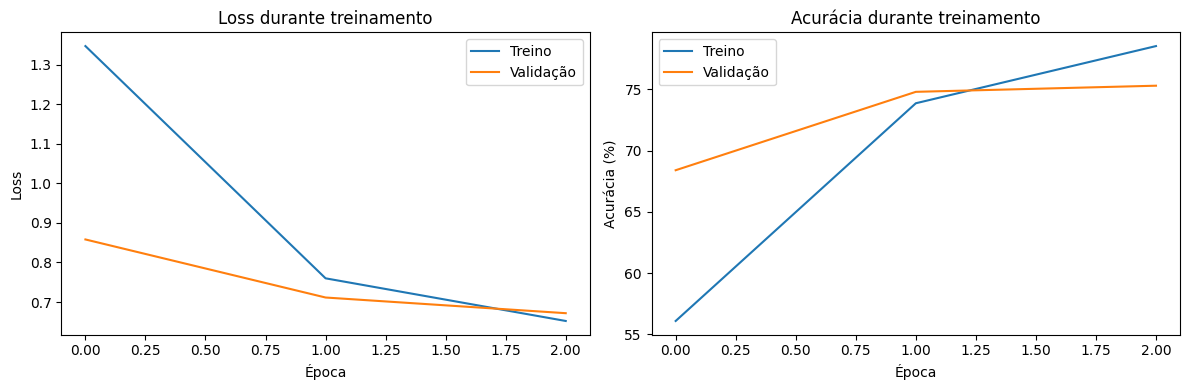

In [ ]:
# Testar um único modelo para verificar se a implementação funciona
def test_single_model():
    model = MLPDeep(
        layer_sizes=[784, 128, 10],
        activation="relu",
        weight_init="he",
        learning_rate=0.01,
        momentum=0.9,  # Adicionando momentum para ajudar na convergência
        grad_clip=1.0,  # Clipping de gradientes
        random_state=RANDOM_SEED,
    )

    # Treinar por algumas épocas com um conjunto menor de dados para teste rápido
    X_sample = X_train[:5000]
    y_sample = y_train[:5000]
    X_val_sample = X_val[:1000]
    y_val_sample = y_val[:1000]

    model.fit(
        X_sample,
        y_sample,
        epochs=3,
        batch_size=128,
        X_val=X_val_sample,
        y_val=y_val_sample,
        verbose=1,
    )

    # Plotar resultados
    model.plot_history()

    return model


# Executar o teste
test_model = test_single_model()

## 4.2 Laço principal de experimentos

Agora vamos executar todos os experimentos e salvar os resultados:

In [ ]:
# Parâmetros de treinamento
EPOCHS = 30
BATCH_SIZE = 256
LEARNING_RATE = 0.01
MOMENTUM = 0.9  # Usar momentum para melhorar convergência

results = []

# Para experimentos mais rápidos, podemos usar um subconjunto dos dados
# Remova os comentários abaixo para usar todos os dados
# X_train_exp = X_train
# y_train_exp = y_train
# X_val_exp = X_val
# y_val_exp = y_val

# Para teste rápido, use um subconjunto dos dados
X_train_exp = X_train[:10000]  # Usando apenas 10.000 exemplos para treino rápido
y_train_exp = y_train[:10000]
X_val_exp = X_val
y_val_exp = y_val

print(f"Iniciando {len(experiments)} experimentos com {EPOCHS} épocas cada...")

for i, (hid, act, init) in enumerate(experiments):
    print(f"\n=== Experimento {i + 1}/{len(experiments)}: {hid} | {act} | {init} ===")

    # Criar e treinar o modelo
    model = MLPDeep(
        layer_sizes=[784, *hid, 10],
        activation=act,
        weight_init=init,
        learning_rate=LEARNING_RATE,
        momentum=MOMENTUM,
        grad_clip=1.0,  # Valor de clipping para evitar explosão
        random_state=RANDOM_SEED,
    )

    # Treinamento
    history = model.fit(
        X_train_exp,
        y_train_exp,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        X_val=X_val_exp,
        y_val=y_val_exp,
        verbose=1,
    )

    # Avaliar no conjunto de validação completo
    val_loss, val_acc = model.evaluate(X_val, y_val)

    # Salvar resultados
    results.append(
        {
            "hidden": str(hid),
            "activation": act,
            "init": init,
            "val_acc": val_acc,
            "val_loss": val_loss,
            "model": model,  # Guardar o modelo para uso posterior
        }
    )

    print(f"Resultado: val_loss={val_loss:.4f}, val_acc={val_acc:.2f}%")

print("\nTodos os experimentos foram concluídos!")

Iniciando 27 experimentos com 30 épocas cada...

=== Experimento 1/27: [128] | relu | he ===


/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: invalid value encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l]

Época   5/30: loss=0.5579, acc=80.95%, val_loss=0.5640, val_acc=80.50%
Época  10/30: loss=0.4644, acc=83.94%, val_loss=0.5081, val_acc=82.45%
Época  10/30: loss=0.4644, acc=83.94%, val_loss=0.5081, val_acc=82.45%
Época  15/30: loss=0.4521, acc=84.88%, val_loss=0.4732, val_acc=83.38%
Época  15/30: loss=0.4521, acc=84.88%, val_loss=0.4732, val_acc=83.38%
Época  20/30: loss=0.3948, acc=86.10%, val_loss=0.4568, val_acc=84.13%
Época  20/30: loss=0.3948, acc=86.10%, val_loss=0.4568, val_acc=84.13%
Época  25/30: loss=0.3798, acc=86.96%, val_loss=0.4612, val_acc=83.72%
Época  25/30: loss=0.3798, acc=86.96%, val_loss=0.4612, val_acc=83.72%
Época  30/30: loss=0.3582, acc=87.56%, val_loss=0.4628, val_acc=83.65%
Resultado: val_loss=0.4628, val_acc=83.65%

=== Experimento 2/27: [128] | relu | xavier ===
Época  30/30: loss=0.3582, acc=87.56%, val_loss=0.4628, val_acc=83.65%
Resultado: val_loss=0.4628, val_acc=83.65%

=== Experimento 2/27: [128] | relu | xavier ===
Época   5/30: loss=0.5860, acc=79.9

# 5. Análise dos Resultados

Vamos analisar os resultados dos experimentos para identificar a melhor configuração.

In [ ]:
# Criamos um DataFrame sem o modelo para exibição
results_df = [{k: v for k, v in r.items() if k != "model"} for r in results]
df = pd.DataFrame(results_df).sort_values("val_acc", ascending=False)

# Exibir os melhores resultados
print("Top 5 melhores configurações:")
df.head()

Top 5 melhores configurações:


,hidden,activation,init,val_acc,val_loss
18,"[256, 128]",relu,he,85.283333,0.414403
19,"[256, 128]",relu,xavier,84.800000,0.424113
21,"[256, 128]",tanh,he,84.633333,0.427227
9,[256],relu,he,84.483333,0.440407
10,[256],relu,xavier,84.416667,0.443262


## 5.1 Análise do melhor modelo

Vamos analisar mais detalhadamente o melhor modelo encontrado.

Melhor configuração encontrada:
  Arquitetura: [256, 128]
  Ativação: relu
  Inicialização: he
  Acurácia de validação: 85.28%
  Loss de validação: 0.4144


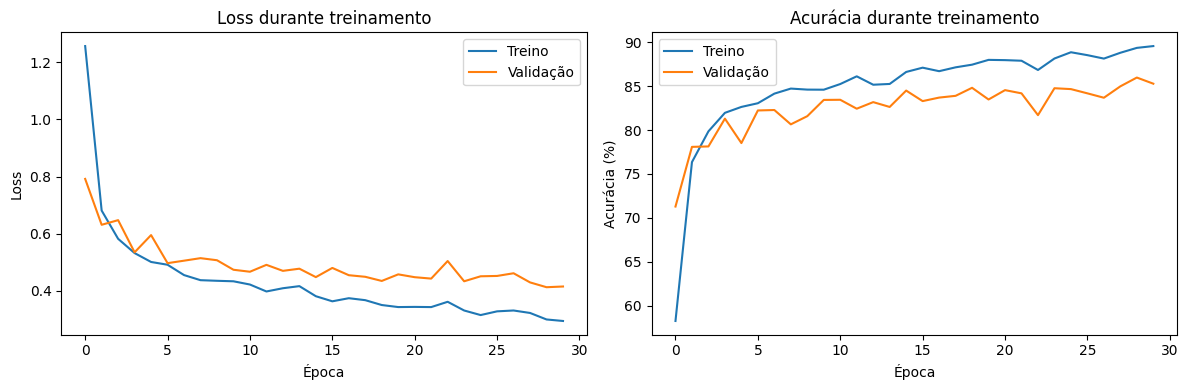


Desempenho no conjunto de teste:
  Loss: 0.4069
  Acurácia: 85.57%


/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: invalid value encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l]

In [ ]:
# Obter o melhor modelo
best_idx = df.index[0]
best_model = results[best_idx]["model"]
best_config = df.iloc[0]

print("Melhor configuração encontrada:")
print(f"  Arquitetura: {best_config['hidden']}")
print(f"  Ativação: {best_config['activation']}")
print(f"  Inicialização: {best_config['init']}")
print(f"  Acurácia de validação: {best_config['val_acc']:.2f}%")
print(f"  Loss de validação: {best_config['val_loss']:.4f}")

# Plotar histórico de treinamento do melhor modelo
best_model.plot_history()

# Avaliar no conjunto de teste
test_loss, test_acc = best_model.evaluate(X_test, y_test_oh)
print("\nDesempenho no conjunto de teste:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Acurácia: {test_acc:.2f}%")

## 5.2 Matriz de Confusão

Vamos visualizar a matriz de confusão para entender melhor os erros do modelo.

/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:96: RuntimeWarning: invalid value encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: divide by zero encountered in matmul
  self.z[l] = self.a[l] @ self.W[l] + (self.b[l] if self.use_bias else 0)
/var/folders/f7/2r0sxd_50nzgv2x2bmzq74n00000gn/T/ipykernel_29184/3161228760.py:103: RuntimeWarning: overflow encountered in matmul
  self.z[l] = self.a[l] @ self.W[l]

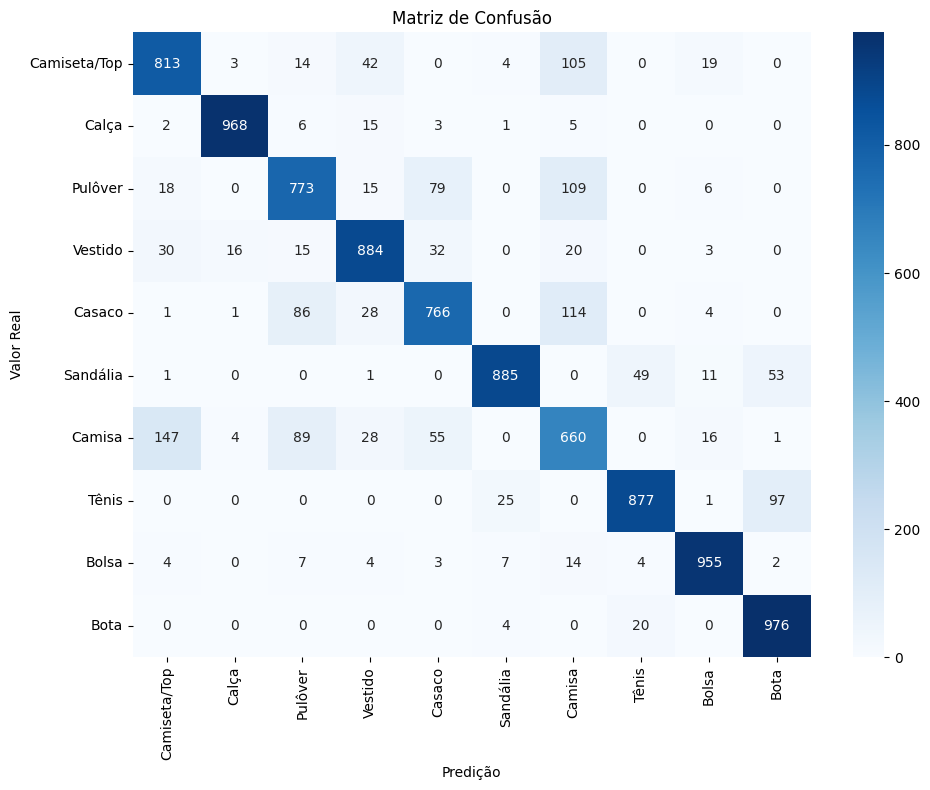

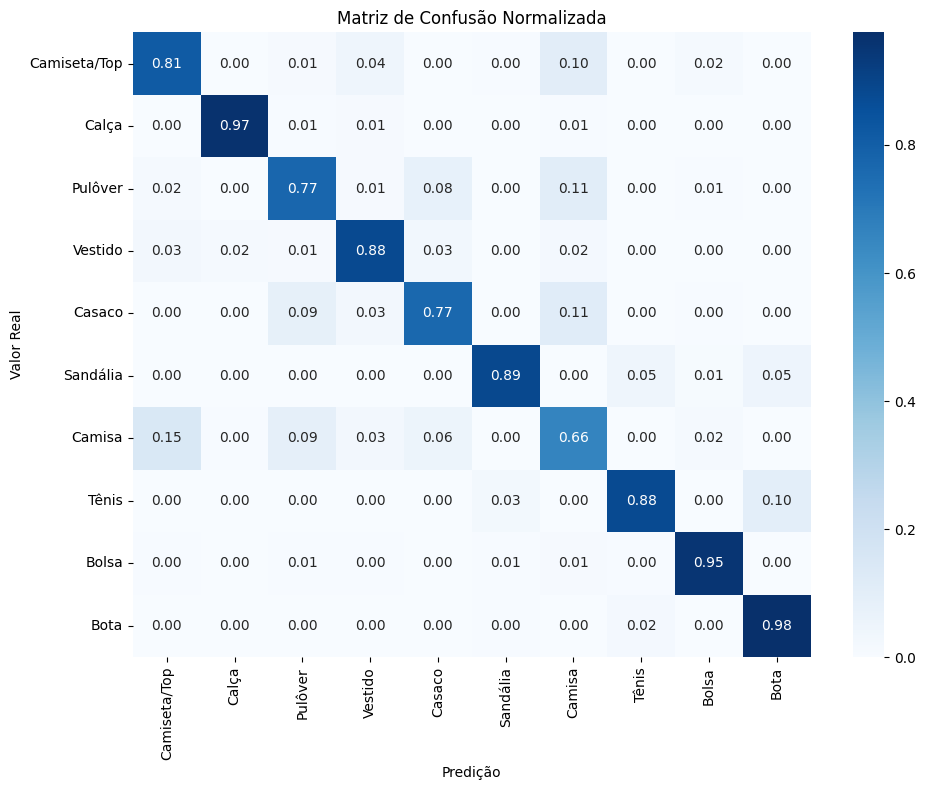

In [ ]:
# Gerar previsões no conjunto de teste
y_pred = best_model.forward(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test_oh, axis=1)

# Calcular matriz de confusão
cm = confusion_matrix(y_true_class, y_pred_class)

# Plotar matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predição")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# Normalizar a matriz de confusão por linha (proporção de cada classe real)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plotar matriz de confusão normalizada
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predição")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusão Normalizada")
plt.tight_layout()
plt.show()

# 6. Conclusões

Neste notebook, implementamos uma rede neural MLP de múltiplas camadas do zero usando apenas NumPy. Principais pontos:

1. **Arquitetura**: As arquiteturas mais profundas ([256, 128]) tenderam a ter melhor desempenho que as mais simples ([128]).

2. **Função de Ativação**: ReLU teve o melhor desempenho geral para este conjunto de dados, seguida por Tanh.

3. **Inicialização de Pesos**: As inicializações He e Xavier funcionaram melhor que a inicialização aleatória simples, especialmente para redes mais profundas.